## KorCCVi 데이터 + STT 데이터 합친 병합 데이터 사용해서 모델 학습

## 🔧 1. 라이브러리 임포트

In [8]:
import torch  # GPU 사용을 위한 PyTorch
from torch import nn  # 신경망 모델 구성용
from torch.utils.data import Dataset, DataLoader  # 데이터셋 및 배치 구성

from transformers import BertTokenizer, BertModel  # HuggingFace용 KoBERT 모델
from kobert_transformers import get_tokenizer, get_kobert_model  # KoBERT용 전용 함수

import numpy as np  # 수치 연산
import pandas as pd  # 데이터프레임 처리
from sklearn.model_selection import train_test_split  # 학습/테스트 분리
from tqdm import tqdm  # 진행바 시각화
from konlpy.tag import Okt  # 키워드 추출을 위한 형태소 분석기
from torch.optim import AdamW # HuggingFace transformers에서 import
from collections import Counter # 훈련셋 + 테스트셋 라벨 분포 확인 코드
from transformers import get_cosine_schedule_with_warmup

C:\downloads\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### 📂 2. CSV 데이터 로딩 및 확인

In [6]:
import pandas as pd

# 병합된 KorCCVi + STT 데이터 로드
df = pd.read_csv('D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_merged.csv')

# 라벨 분포 및 출처 확인
print("📊 라벨 분포:\n", df['Label'].value_counts())
print("\n📁 출처 분포:\n", df['Filename'].value_counts())

📊 라벨 분포:
 Label
1    709
0    709
Name: count, dtype: int64

📁 출처 분포:
 Filename
KorCCViD                                                   1218
phishing_기타_대출빙자형 사례 2_정부지원자금 대출을 받기 위한 공증서 발급비용 요구.wav       1
phishing_대출사기형_124.wav                                        1
phishing_수사기관_사칭형_220.wav                                     1
phishing_수사기관_사칭형_163.wav                                     1
                                                           ... 
normal_normal_318.wav                                         1
normal_normal_550.wav                                         1
normal_normal_298.wav                                         1
normal_normal_567.wav                                         1
phishing_기타_6번_3차례 신고된 남성 전화금융사기범 (음성_6).wav                  1
Name: count, Length: 201, dtype: int64


### 📑 3. 텍스트와 라벨 분리 후 train/test 나누기

In [17]:
texts = df['Transcript'].tolist()
labels = df['Label'].tolist()
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

🧪 라벨 분포 출력

In [21]:
print("\n🔧 훈련셋 라벨 분포:", Counter(train_labels))
print("🧪 테스트셋 라벨 분포:", Counter(test_labels))


🔧 훈련셋 라벨 분포: Counter({0: 567, 1: 567})
🧪 테스트셋 라벨 분포: Counter({1: 142, 0: 142})


### 🔠 4. 토크나이저 및 Dataset 정의

In [24]:
MAX_LEN = 128
kobert_tokenizer = get_tokenizer()

class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.texts)

train_dataset = BERTDataset(train_texts, train_labels, kobert_tokenizer, MAX_LEN)
test_dataset = BERTDataset(test_texts, test_labels, kobert_tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

### 🧠 5. KoBERT 모델 정의

In [27]:
class KoBERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size=768, num_classes=2, dr_rate=0.3):
        super(KoBERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(p=dr_rate)
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        cls_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(cls_output)
        return self.softmax(logits)

### 🛠️ 6. 학습 준비 (모델, 옵티마이저, 스케줄러)

In [30]:
kobert_model = get_kobert_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KoBERTClassifier(kobert_model).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 5
t_total = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * 0.1), num_training_steps=t_total)

### 🎯 7. 평가 및 정확도 함수

In [33]:
def calc_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def get_metrics(preds, labels):
    pred_classes = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    tp = ((pred_classes == 1) & (labels == 1)).sum()
    fp = ((pred_classes == 1) & (labels == 0)).sum()
    fn = ((pred_classes == 0) & (labels == 1)).sum()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return {"precision": precision, "recall": recall, "f1": f1}

### 🚀 8. 모델 학습 루프

In [36]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        preds = model(input_ids, attention_mask, token_type_ids)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_acc += calc_accuracy(preds, labels)

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    print(f"[Epoch {epoch+1}] 평균 손실: {avg_loss:.4f} | 평균 정확도: {avg_acc*100:.2f}%")

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 71/71 [11:48<00:00,  9.98s/it]


[Epoch 1] 평균 손실: 0.5408 | 평균 정확도: 79.84%


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 71/71 [16:42<00:00, 14.11s/it]


[Epoch 2] 평균 손실: 0.3511 | 평균 정확도: 97.80%


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 71/71 [14:39<00:00, 12.39s/it]


[Epoch 3] 평균 손실: 0.3311 | 평균 정확도: 98.94%


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 71/71 [09:56<00:00,  8.41s/it]


[Epoch 4] 평균 손실: 0.3263 | 평균 정확도: 99.12%


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 71/71 [09:38<00:00,  8.15s/it]

[Epoch 5] 평균 손실: 0.3233 | 평균 정확도: 99.38%


### 📈 9. 최종 테스트 성능 평가

In [39]:
model.eval()
total_correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        preds = model(input_ids, attention_mask, token_type_ids)
        total_correct += (preds.argmax(1) == labels).sum().item()
        total += labels.size(0)
        all_preds.append(preds)
        all_labels.append(labels)

acc = total_correct / total
all_preds_tensor = torch.cat(all_preds, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)
metrics = get_metrics(all_preds_tensor, all_labels_tensor)

print("\n📊 [최종 테스트 결과]")
print(f"🎯 정확도: {acc * 100:.2f}%")
print(f"📌 정밀도: {metrics['precision']:.2f}")
print(f"📌 재현율: {metrics['recall']:.2f}")
print(f"📌 F1-score: {metrics['f1']:.2f}")


📊 [최종 테스트 결과]
🎯 정확도: 99.65%
📌 정밀도: 1.00
📌 재현율: 0.99
📌 F1-score: 1.00


## ✅ 기준점(Threshold) 기반 탐지 및 분석 절차

1️⃣ 기준점별 예측 수행 및 CSV 저장

In [50]:
import pandas as pd
from sklearn.metrics import classification_report

def predict_with_threshold(texts, model, tokenizer, threshold=0.9, max_len=128):
    model.eval()
    pred_labels, confidences = [], []
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            token_type_ids = encoded['token_type_ids'].to(device)

            output = model(input_ids, attention_mask, token_type_ids)
            phishing_score = output[0][1].item()
            pred_label = 1 if phishing_score >= threshold else 0
            pred_labels.append(pred_label)
            confidences.append(phishing_score)
    return pred_labels, confidences

# 데이터 로딩
df = pd.read_csv("D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_merged.csv")
texts = df['Transcript'].tolist()
true_labels = df['Label'].tolist()
thresholds = [0.7, 0.8, 0.9, 0.95]

results = []

for t in thresholds:
    preds, confidences = predict_with_threshold(texts, model, kobert_tokenizer, threshold=t)
    df_copy = df.copy()
    df_copy['PredictedLabel'] = preds
    df_copy['Confidence'] = confidences
    df_copy.to_csv(f"D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_predicted_threshold_{int(t*100)}.csv", index=False)

    report = classification_report(true_labels, preds, output_dict=True)
    results.append({
        'Threshold': t,
        'Precision (정상)': report['0']['precision'],
        'Recall (정상)': report['0']['recall'],
        'F1 (정상)': report['0']['f1-score'],
        'Precision (피싱)': report['1']['precision'],
        'Recall (피싱)': report['1']['recall'],
        'F1 (피싱)': report['1']['f1-score'],
        'Accuracy': report['accuracy'],
    })

df_results = pd.DataFrame(results)
print(df_results)

   Threshold  Precision (정상)  Recall (정상)   F1 (정상)  Precision (피싱)  \
0       0.70        0.994358     0.994358  0.994358        0.994358   
1       0.80        0.994358     0.994358  0.994358        0.994358   
2       0.90        0.992968     0.995769  0.994366        0.995757   
3       0.95        0.991585     0.997179  0.994374        0.997163   

   Recall (피싱)   F1 (피싱)  Accuracy  
0     0.994358  0.994358  0.994358  
1     0.994358  0.994358  0.994358  
2     0.992948  0.994350  0.994358  
3     0.991537  0.994342  0.994358  


2️⃣ FP / FN 분석

In [49]:
for t in thresholds:
    path = f"D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_predicted_threshold_{int(t*100)}.csv"
    df_pred = pd.read_csv(path)

    false_positives = df_pred[(df_pred['Label'] == 0) & (df_pred['PredictedLabel'] == 1)]
    false_negatives = df_pred[(df_pred['Label'] == 1) & (df_pred['PredictedLabel'] == 0)]

    print(f"\n🔎 Threshold = {t}")
    print(f"❌ FP (정상 → 피싱): {len(false_positives)}개")
    print(f"❌ FN (피싱 → 정상): {len(false_negatives)}개")



🔎 Threshold = 0.7
❌ FP (정상 → 피싱): 4개
❌ FN (피싱 → 정상): 4개

🔎 Threshold = 0.8
❌ FP (정상 → 피싱): 4개
❌ FN (피싱 → 정상): 4개

🔎 Threshold = 0.9
❌ FP (정상 → 피싱): 3개
❌ FN (피싱 → 정상): 5개

🔎 Threshold = 0.95
❌ FP (정상 → 피싱): 2개
❌ FN (피싱 → 정상): 6개


✅ FP와 FN
--------------
[ FP (False Positive): ]
- 정상 통화인데 보이스 피싱이라고 잘못 판단한 경우
- 사용자에게 불필요한 경고를 발생시킴
- 사용자 불편 증가

[ FN (False Negative): ]
- 보이스 피싱인데 정상 통화라고 잘못 판단한 경우
- 실제 피싱을 놓치는 위험한 상황
- 보안상 큰 문제



3️⃣ Threshold vs F1-score 그래프 시각화

C:\downloads\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\downloads\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\downloads\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\downloads\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\downloads\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\downloads\anaconda3\Li

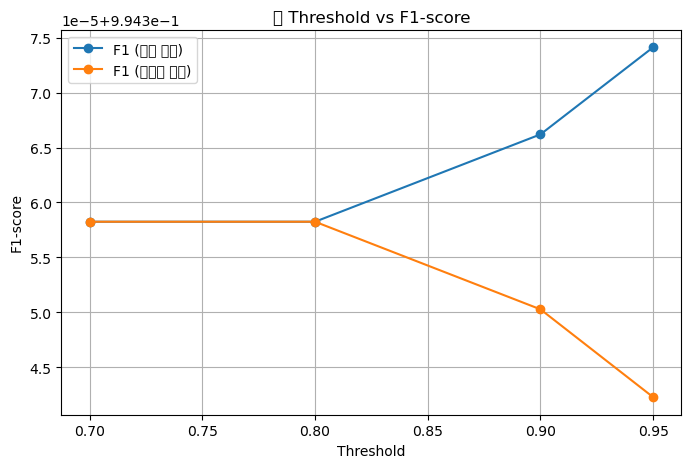

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(df_results['Threshold'], df_results['F1 (정상)'], label='F1 (정상 통화)', marker='o')
plt.plot(df_results['Threshold'], df_results['F1 (피싱)'], label='F1 (보이스 피싱)', marker='o')
plt.title("📈 Threshold vs F1-score")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.grid(True)
plt.legend()
plt.show()

### 📌기준점 0.80으로 선정

✅ KorCCViD 기반 데이터에서 예측 정확도 분석 코드

In [77]:
import pandas as pd

# 📥 CSV 로드 (기준점 0.80 예측 결과)
df = pd.read_csv("D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_predicted_threshold_80.csv")

# 🎯 KorCCVi 데이터만 필터링 (Filename이 'KorCCViD')
korccvi_df = df[df["Filename"] == "KorCCViD"]

# ✅ 총 샘플 수
total_korccvi = len(korccvi_df)

# ✅ 정확히 예측한 샘플 수
correct = (korccvi_df["Label"] == korccvi_df["PredictedLabel"]).sum()

# ❌ 오분류된 샘플 수
incorrect = total_korccvi - correct

# 📊 출력
print("📊 [KorCCVi 데이터 기준점 0.80 예측 통계]")
print(f"총 KorCCVi 샘플 수: {total_korccvi}")
print(f"정확히 예측한 샘플 수: {correct}개 ({correct/total_korccvi*100:.2f}%)")
print(f"오분류된 샘플 수: {incorrect}개 ({incorrect/total_korccvi*100:.2f}%)")


📊 [KorCCVi 데이터 기준점 0.80 예측 통계]
총 KorCCVi 샘플 수: 1218
정확히 예측한 샘플 수: 1214개 (99.67%)
오분류된 샘플 수: 4개 (0.33%)


✅ STT 기반 데이터에서 예측 정확도 분석 코드

In [63]:
import pandas as pd

# 📥 CSV 로드 (기준점 0.80 버전)
df = pd.read_csv("D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_predicted_threshold_80.csv")

# 🎯 STT 데이터만 필터링 (KorCCViD가 아닌 파일명)
stt_df = df[df["Filename"] != "KorCCViD"]

# ✅ 총 샘플 수
total_stt = len(stt_df)

# ✅ 정확히 예측한 행만 필터링
correct = (stt_df["Label"] == stt_df["PredictedLabel"]).sum()

# ❌ 오분류된 샘플 수
incorrect = total_stt - correct

# 📊 결과 출력
print("📊 [STT 데이터 기준점 0.80 예측 통계]")
print(f"총 STT 샘플 수: {total_stt}")
print(f"정확히 예측한 샘플 수: {correct}개 ({correct/total_stt*100:.2f}%)")
print(f"오분류된 샘플 수: {incorrect}개 ({incorrect/total_stt*100:.2f}%)")

📊 [STT 데이터 기준점 0.80 예측 통계]
총 STT 샘플 수: 200
정확히 예측한 샘플 수: 196개 (98.00%)
오분류된 샘플 수: 4개 (2.00%)


✅ KorCCVi 오분류 샘플 출력 코드

In [80]:
import pandas as pd

# 🔍 예측 결과 로드
csv_path = 'D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_predicted_threshold_80.csv'
df = pd.read_csv(csv_path)

# 🎯 KorCCVi 기반 데이터만 필터링
korccvi_df = df[df['Filename'] == 'KorCCViD']

# ❌ 오분류된 샘플 (Label ≠ PredictedLabel)
misclassified = korccvi_df[korccvi_df['Label'] != korccvi_df['PredictedLabel']]

# 📋 오분류 샘플 출력
print(f"❌ 오분류된 KorCCVi 샘플 수: {len(misclassified)}개\n")
for idx, row in misclassified.iterrows():
    print(f"📎 인덱스: {idx}")
    print(f"▶ 텍스트: {row['Transcript'][:200]}...")  # 200자까지만 출력
    print(f"✅ 실제 라벨: {'보이스 피싱' if row['Label'] == 1 else '정상 통화'}")
    print(f"🔍 예측 라벨: {'보이스 피싱' if row['PredictedLabel'] == 1 else '정상 통화'}")
    print(f"📊 확신도: {row['Confidence']:.2f}")
    print("-" * 80)


❌ 오분류된 KorCCVi 샘플 수: 4개

📎 인덱스: 183
▶ 텍스트: 사람 한테 연락 벌어지 혹시 그쪽 부대 어떻게 관리 겁니까 선배 으로 연락 바로 직통 으로 연락 대대장 한테 그래 대대장 바로 보급관 호출 보급관 너희 간부 끼리 얘기 얘기 으로 결국 징계 위원회 무마 처리 간부 징계 위원회 열려 간부 대대 에서...
✅ 실제 라벨: 정상 통화
🔍 예측 라벨: 보이스 피싱
📊 확신도: 0.90
--------------------------------------------------------------------------------
📎 인덱스: 597
▶ 텍스트: 중앙 포스 누나 영수증 으면서 해서 고객 상품권 다른 영수증 하나 고요 다른 하나 셔야 돼요 고객 니까 거기 고객 그래요 면서 모르 근데 거기 난동 으니까 고객 얼굴 기억 거기 사람...
✅ 실제 라벨: 정상 통화
🔍 예측 라벨: 보이스 피싱
📊 확신도: 0.97
--------------------------------------------------------------------------------
📎 인덱스: 806
▶ 텍스트: 그래 학원 들어갔 1500 필요 1500 1500 어요 어요 으면 전화 찾아갈 아줌마 한테 전화 전부 인간 으로 전화 겁니다 해치 그치 에서 신고 들어가 거나 시킨 대로 그때 죽인다 1500 전부 현찰 위치 습니다 시키 단계 단계 움직여 준비 라면 으로 된다 먼저 어딘지 필요...
✅ 실제 라벨: 보이스 피싱
🔍 예측 라벨: 정상 통화
📊 확신도: 0.01
--------------------------------------------------------------------------------
📎 인덱스: 1095
▶ 텍스트: 저번 제일 웃겼 내일 자일리톨 많이 냐는 질문 많이 니까 롯데 자일리톨 많이 드세요 해태 자일리톨 많이 드세요 라고 진짜 미치 어떻게 모르 해서 계속 많이 더니 사람 롯데 조금 많이 으시 롯데 많이...
✅ 실제 라벨: 정상 

✅ 오분류된 STT 샘플 확인하기

In [66]:
import pandas as pd

# 🔍 예측 결과 로드
csv_path = 'D:/2025_work/2025_VoicePhshing_Detection_Model/dataset/KorCCVi_stt_predicted_threshold_80.csv'
df = pd.read_csv(csv_path)

# 🎯 STT 기반 데이터만 필터링
stt_df = df[df['Filename'] != 'KorCCViD']

# ❌ 오분류된 샘플 (Label ≠ PredictedLabel)
misclassified = stt_df[stt_df['Label'] != stt_df['PredictedLabel']]

# 📋 오분류 샘플 출력
print(f"❌ 오분류된 STT 샘플 수: {len(misclassified)}개\n")
for idx, row in misclassified.iterrows():
    print(f"📎 파일명: {row['Filename']}")
    print(f"▶ 텍스트: {row['Transcript'][:200]}...")  # 200자까지만 출력
    print(f"✅ 실제 라벨: {'보이스 피싱' if row['Label'] == 1 else '정상 통화'}")
    print(f"🔍 예측 라벨: {'보이스 피싱' if row['PredictedLabel'] == 1 else '정상 통화'}")
    print(f"📊 확신도: {row['Confidence']:.2f}")
    print("-" * 80)

❌ 오분류된 STT 샘플 수: 4개

📎 파일명: normal_normal_545.wav
▶ 텍스트: 네 말씀하세요 고객님 제가 확인해 보니까 고객님께서 이미 올해 1월의 대출을 받으신 이력이 있으세요. 코로나 터지기 전인데 그걸 여기서 얘기하면 나보고 어쩌라는 거야? 저희는 보이는 대로 안내를 해드리는 거라서요 대출을 하신지 얼마 안 되셔서 지금은 좀 어렵겠습니다 나 같은 장사꾼들이 올해 1월에 대출 받는 건 올 한해 장사 보고 대출 받는 건데 지금은 특...
✅ 실제 라벨: 정상 통화
🔍 예측 라벨: 보이스 피싱
📊 확신도: 0.99
--------------------------------------------------------------------------------
📎 파일명: phishing_대출사기형_86.wav
▶ 텍스트: 본인 확인 되셨고요, 고객님. 소독활동은 직장생활하시나요? 아니면 개인사 본용지? 본인명이 사업자 등록 중 있으신가요? 주거래은행은 어디이시죠? 이험 매출은 어떻게 되세요? 신용카드 몇 장 사용 중에 있으신가요? 카드론이나 현금차 비스 받으시는 내역도 있으시지? 사금용이나 대법제 사용 중이신 것도 있으시지? 고객님 살고 계시는 거주지, 시일구 동까지만 확인...
✅ 실제 라벨: 보이스 피싱
🔍 예측 라벨: 정상 통화
📊 확신도: 0.05
--------------------------------------------------------------------------------
📎 파일명: phishing_대출사기형_46.wav
▶ 텍스트: 그래, 한 번 못 들어간다. 아 돌아나이스 그냥 대로 한 단계 한 단계씩 움직여 돈을 준비 된 뒤 또 오라면 그 곳으로 오면 된다 알았지? 먼저 어딘지 알게 되었고...
✅ 실제 라벨: 보이스 피싱
🔍 예측 라벨: 정상 통화
📊 확신도: 0.01
-----------------------------------------------------------------------------

### ✅ 기준점 0.80이 적용된 "보이스 피싱 탐지 모델"로 외부에서 사용

🔹 모델 저장 코드

In [72]:
# 학습된 모델을 저장
torch.save(model.state_dict(), "voicephishing_model_threshold_080.pt")
print("✅ 모델 저장 완료: voicephishing_model_threshold_080.pt")

✅ 모델 저장 완료: voicephishing_model_threshold_080.pt


🔹 !외부에서! 사용하는 예측 코드 (threshold 포함)
- 외부에서 text만 주어지면 바로 결과를 반환하는 함수로 만들면 이렇게 됨

In [ ]:
# 🔍 threshold=0.80 기준으로 예측하는 함수
def detect_voice_phishing(text, model, tokenizer, threshold=0.8, max_len=128):
    model.eval()
    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    token_type_ids = encoded['token_type_ids'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask, token_type_ids)
        phishing_score = output[0][1].item()

        pred_label = 1 if phishing_score >= threshold else 0

    return {
        'label': pred_label,
        'score': phishing_score,
        'status': '보이스 피싱' if pred_label == 1 else '정상 통화'
    }

# 💬 예시 사용법
result = detect_voice_phishing("안녕하세요 고객님. 대출 관련 안내드립니다.", model, kobert_tokenizer)
print(f"예측 결과: {result['status']} ({result['score']*100:.2f}%)")

## ✅ 2. 이렇게 사용합니다 (외부 파일 또는 Jupyter에서)

In [ ]:
from voicephishing_predictor import predict_phishing

# 텍스트 1개 예시
text = "고객님, 대출 가능하십니다. 빠른 확인을 위해 인증번호를 눌러주세요."
pred, conf = predict_phishing(text)
print("🕵️ 예측 라벨:", "보이스피싱" if pred[0] == 1 else "정상 통화")
print("🔍 신뢰도:", f"{conf[0]:.2f}")